
      APPLICATION  D'UNE METHODE D'ACCEPTATION-REJET POUR UNE SIMULATION BAYESIENNE A POSTERIORI




                  Donnees X  ~ Loi NORMALE (THETA,1). La derniere donnee observee est
                                                      censuree a droite.

                  A priori sur THETA = Loi NORMALE (MU,1) d'hyperparametre MU 






In [6]:
%matplotlib notebook
import sys, os
sys.path.append('../')

import math as m
import statistics as s
import random as r
import numpy as np
import numpy.linalg as la
from numpy import random as rand

import scipy
# import scipy.ndimage as sn
# from scipy.ndimage.filters import gaussian_filter
from scipy.stats import norm
from scipy.stats import uniform
from statistics import mean

import pandas as pd
import seaborn as sns
#plt.rcParams['font.size'] = 20

import warnings
warnings.filterwarnings('ignore')

#sns.set()

log = np.vectorize(m.log)
exp = np.vectorize(m.exp)
sqrt = np.vectorize(m.sqrt)

In [7]:
donnees = np.array([0.8114032, -0.4631576, -0.5984133,  1.5006175,  0.2123149, -1.0101033,1.0199253, -2.5994554, -0.3684774,  0.8263161,  0.4572680, -0.7240380,-0.3134977, -0.3772193, 0.5],float)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from IPython.display import clear_output
import time


def acceptation_rejet(option=1,donnees=donnees,N=5000,mu=0):
    
    # informations sur les données
    n = len(donnees)
    
    # log-densité de la loi a priori sur theta
    def log_prior(theta):
        res = -(1/2)*log(2*m.pi) - (1/2)*(theta-mu)**2
        return res
    def prior_dens(x):
        res = exp(log_prior(x))
        return res
    
    # log-densité de la loi a posteriori sur theta définie à un facteur près
    moy_post = (mu + sum(donnees[0:(n-2)]))/n
    sigma_post = sqrt(1/n)
    def log_post(theta):
        ll1 = - (1/(2*sigma_post**2))*(theta-moy_post)**2
        ll2 = log(1-norm.cdf(donnees[n-1]-theta,0,1))
        return ll1+ll2
    
    # log-densité de la loi de tirage de theta
    if option==1:          # posterior sans tenir compte de la censure
        moy = moy_post
        sigma = sigma_post
    else:                  # loi a priori
        moy = mu
        sigma = 1
    def log_instr(theta):
        res = -(1/2)*log(2*m.pi) - log(sigma) - (1/(2*sigma**2))*((theta-moy)**2)
        return res
    def inst_dens(x):
        return np.exp(log_instr(x))
    
    # constante utilisée pour l'acceptation-rejet (notée K dans le cours)
    if option==1:
        M = sqrt(2*m.pi/n)
    else:
        res = mean(donnees[0:n-1]-mu)
        M = sqrt(2*m.pi)*exp(0.5*(res**2)*(1-sqrt(n)))
                                 
    # BOUCLE DE SIMULATION

    NN = m.floor(N/100)+1
    theta_ok = np.empty(1)
    theta_nok = np.empty(1) #theta.ref in R notebook
    nb_acc = np.empty(1)
    
    
    while True:

        # Ici mettre en place le test 
        theta = norm.rvs(moy, sigma, size=NN)
        U = np.array(uniform.rvs(0, 1, size=NN), float)
        test = (log(U) <= log_post(theta) - log_instr(theta) - log(M))
        theta_ok = np.concatenate((theta_ok, theta[test]))
        theta_nok = np.concatenate((theta_nok, theta[test==False]))
        nb_acc = np.concatenate((nb_acc, np.array([sum(test)/len(test)])))

        
        # Concaténation
        theta_ok = np.concatenate((theta_ok,theta[test]))
        theta_nok = np.concatenate((theta_nok,theta[test==False]))
        nb_acc = np.concatenate((nb_acc,np.array([sum(test)/len(test)])))

        
        ### plot real time animation ###
        clear_output(wait=True)
        
        # define plots
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
        
        ax1.set_title('Proportion d acceptation')
        ax2.set_title('Histogramme des simulations acceptees')
        ax1.plot(np.cumsum(nb_acc)/range(len(nb_acc)))
        
        xx = np.linspace(min(donnees),max(donnees),100)
        sns.distplot(theta_ok,ax = ax2) #histogramme
        ax2.plot(xx,inst_dens(xx),'--',label='instrumental density')
        ax2.plot(xx,prior_dens(xx),'--',label='a priori density')
        ax2.plot(donnees[:-1],np.zeros(len(donnees[:-1])),'+', label = 'donnees iid')
        ax2.plot(donnees[-1],0,'o',label='donnee censuree')

        ax2.set_ylim(-0.2,2) 
        ax2.legend(loc='upper left')
        
        #force show an optionally freeze for t seconds
        plt.show();
        #t = 0.001
        #time.sleep(t)
        
        if len(theta_ok)>=N:
                    break
                                
# Estimation de la constante de normalisation et validation graphique de la simulation obtenue
    prob_acceptation = len(theta_ok)/(len(theta_ok) + len(theta_nok))
    constante_C = 1/(M*prob_acceptation)
    def post_dens(x):
        res = constante_C*exp(log_post(x))
        return res

    
    ### Save animation to .mp4 ###
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    
    def animate(i): #animation function

        ax2.clear()

        ax1.set_title('Proportion d acceptation')
        ax2.set_title('Histogramme des simulations acceptees')
        ax1.plot(np.cumsum(nb_acc[:i])/range(len(nb_acc[:i])))
        
        xx = np.linspace(min(donnees),max(donnees),100)
        sns.distplot(theta_ok[:int(sum(nb_acc[:i]))],ax = ax2) #histogramme
        # int(sum(nb_acc[:i])) corresponds to the number of accepted samples at time i
        ax2.plot(xx,inst_dens(xx),'--',label='instrumental density')
        ax2.plot(xx,prior_dens(xx),'--',label='a priori density')
        ax2.plot(donnees[:-1],np.zeros(len(donnees[:-1])),'+', label = 'donnees iid')
        ax2.plot(donnees[-1],0,'o',label='donnee censuree')
        
        
        ax2.set_ylim(-0.2,2) 
        
        ax2.legend(loc='upper left')
        
        return ax1, ax2, 

    # create animation using function below
    print('Creating animated plot using stored data...')
    ani = FuncAnimation(fig, animate, frames = N + len(theta_nok), interval=40)
    clear_output(wait=True)
    
    # Save locally (requires ffmpeg)
    Writer = writers['ffmpeg']
    writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('Animated_plot.mp4', writer=writer)

RuntimeError: Requested MovieWriter (ffmpeg) not available

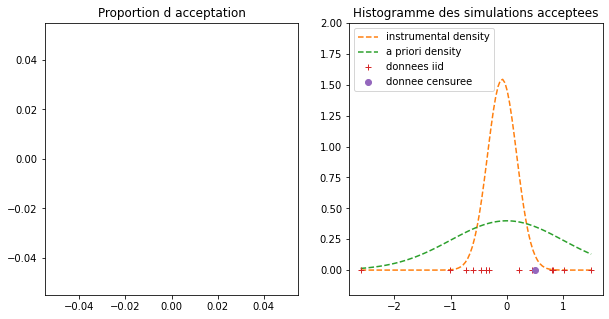

In [11]:
acceptation_rejet(option=1,N=50,mu=0)